In [2]:
#import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# Import the relevant functions from `sklearn.ensemble`, `sklearn.model_selection`, and `sklearn.metrics`.
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
#package to save models
import pickle
#log-likleihood
import itertools

Load the data. Since the df is the same employed on Task3, the already cleaned dataset is loaded. 
To see the cleaning phase, go to task3. 

In [3]:
#load data
loandf = pd.read_csv("loandf_cleaned.csv")
loandf.head(5)

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,5221.545193,3915.471226,78039.38546,5,605,0
1,5,1958.928726,8228.752520,26648.43525,2,572,1
2,0,3363.009259,2027.830850,65866.71246,4,602,0
3,0,4766.648001,2501.730397,74356.88347,5,612,0
4,1,1345.827718,1768.826187,23448.32631,6,631,0


The 2 variables of interest are FICO and default. Thus, the df is subset to just these features.

In [4]:
fico = loandf.drop(columns = ["credit_lines_outstanding" ,
                              "loan_amt_outstanding",
                              "total_debt_outstanding",
                              "income",
                              "years_employed"])
fico.head(5)

,fico_score,default
0,605,0
1,572,1
2,602,0
3,612,0
4,631,0


Check for data type, number of observations and unique values.

In [5]:
#data type
fico.dtypes

fico_score    int64
default       int64
dtype: object

In [6]:
#observations number
fico.count()

fico_score    10000
default       10000
dtype: int64

In [7]:
fico.nunique()

fico_score    374
default         2
dtype: int64

In the fico-score, there are 374 unique values. This means different peoples have the same FICO score.
Showing unqiue values helps in understanding our data.

In [8]:
#show fico unique values
np.sort(fico['fico_score'].unique())

array([408, 409, 418, 425, 438, 440, 441, 444, 447, 449, 450, 455, 456,
       459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471,
       472, 473, 474, 475, 476, 477, 479, 480, 481, 482, 483, 484, 485,
       486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
       499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511,
       512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524,
       525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550,
       551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576,
       577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589,
       590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602,
       603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615,
       616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 62

This gives an idea of how fico-scores are distributed. The two major insights are:
- There are no FICO < 400
- There is at least 1 user that has a perfect FICO (=850).

K-MEANS CLUSTERING

Opting for a K-mean clustering techniques seems reasonal in order to assign fico scores to different clusters. 

To do that, various k-model with different k-values (from 2 to 10) are fitted. Then, by considering inertia and silhoutte, the ones who performs better is chosen.

In [9]:
#Function: Fit K-means and evaluate inertia for different values of k.
def kmeans_inertia(num_clusters, x_vals):
    '''
    Fits a KMeans model for different values of k.
    Calculates an inertia score for each k value.

    Args:
        num_clusters: (list of ints)  - The different k values to try
        x_vals:       (array)         - The training data

    Returns: 
        inertia:      (list)          - A list of inertia scores, one for each \
                                      value of k
    '''

    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    
    return inertia

In [10]:
#returna list of inertia from k = 2 to k = 10
# Create a list from 2-10. 
num_clusters = [i for i in range(2, 11)]
#run the function
inertia = kmeans_inertia(num_clusters, fico)
inertia

[13494420.954858566,
 7055562.66973003,
 4394047.918116782,
 3006569.544252247,
 2145877.327886358,
 1630553.2546448326,
 1259215.9119734354,
 1036387.1003047191,
 840800.1719741569]

Text(0, 0.5, 'Inertia')

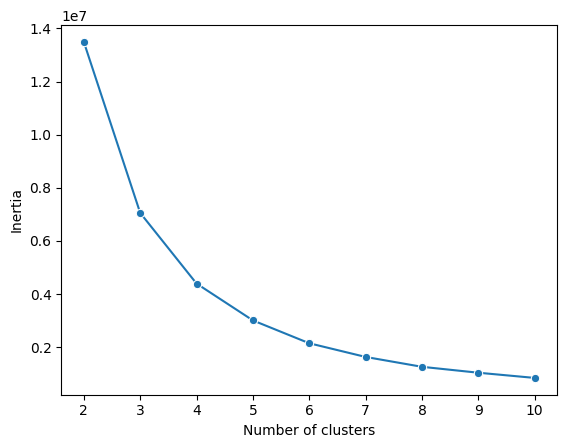

In [11]:
#show the elbow plot
plot = sns.lineplot(x = num_clusters, y = inertia, marker = "o")
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")

It looks like the elbow is at k = 6. Let's check if this is the case by computing the silhoutte score.

In [12]:
# Write a function to return a list of each k-value's Silhoutte score.
def kmeans_sil(num_clusters, x_vals):
    '''
    Fits a KMeans model for different values of k.
    Calculates a silhouette score for each k value

    Args:
        num_clusters: (list of ints)  - The different k values to try
        x_vals:       (array)         - The training data

    Returns: 
        sil_score:    (list)          - A list of silhouette scores, one for each \
                                      value of k
    '''
  
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))
    
    return sil_score

In [13]:
#compute silhouette score
sil_score = kmeans_sil(num_clusters, fico)
sil_score

[np.float64(0.5500835868264148),
 np.float64(0.5303606297330808),
 np.float64(0.5212093057108261),
 np.float64(0.5174207683521698),
 np.float64(0.5195631432209383),
 np.float64(0.5206414076496715),
 np.float64(0.5193118995420996),
 np.float64(0.5202441904811017),
 np.float64(0.5177146988127617)]

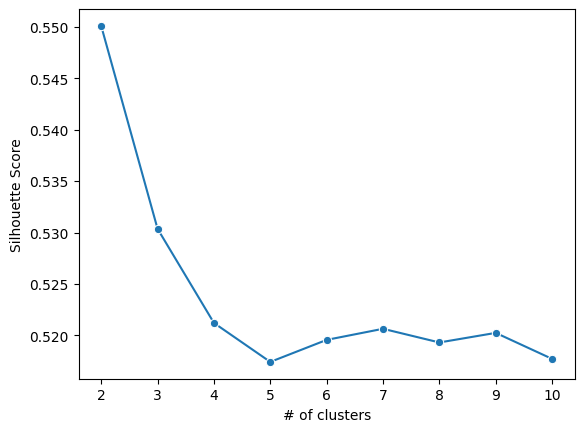

In [14]:
# Create a line plot.
plot = sns.lineplot(x=num_clusters, y=sil_score, marker='o')
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

Considering both measures altogether, the optimal choice for k may be k = 3.
It is time to build the model.

In [15]:
#instantiate a 6-k model
kmeans3 = KMeans(n_clusters=3, random_state=42)
#fit the model
kmeans3.fit(fico)
#define the clusters
cluster = kmeans3.fit_predict(fico)

In [16]:
#print unique labels of the fit model
# Print slice of first 5 labels in kmeans6
print(kmeans3.labels_[:5])
# Print unique labels.
print('Unique labels:' , np.unique(kmeans3.labels_))

[1 0 1 1 1]
Unique labels: [0 1 2]


Plot the various clusters.

/var/folders/kq/9y2hbp4d7kd51hn98cs1r2zm0000gn/T/ipykernel_3079/2654137145.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster')


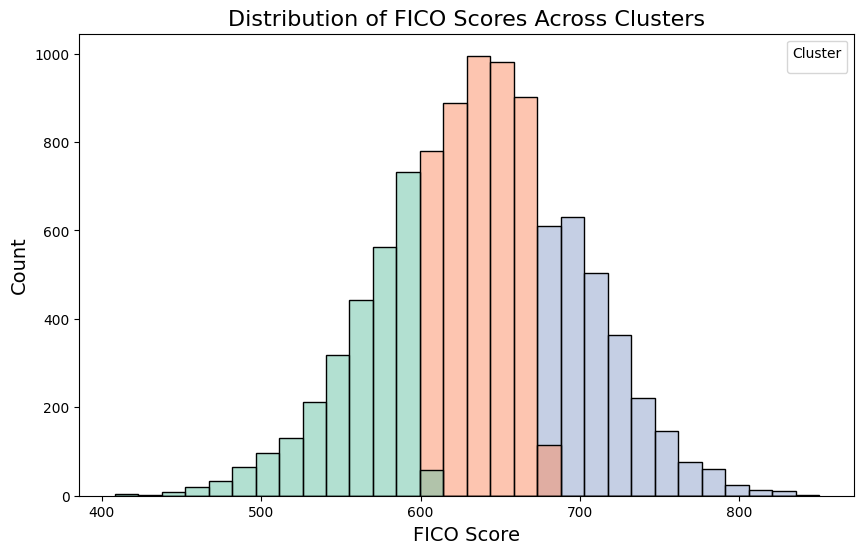

In [17]:
# Add the cluster labels to the DataFrame
fico['cluster'] = cluster
# Visualize the clusters with a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=fico, x='fico_score', hue='cluster', bins=30, kde=False, palette='Set2')
plt.title('Distribution of FICO Scores Across Clusters', fontsize=16)
plt.xlabel('FICO Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Cluster')
plt.show()

Finally, compute the default rate (proportion of defaults) in each cluster.

         total_observations  defaults  default_rate
cluster                                            
0                      2682       972      0.362416
1                      4659       714      0.153252
2                      2659       165      0.062053


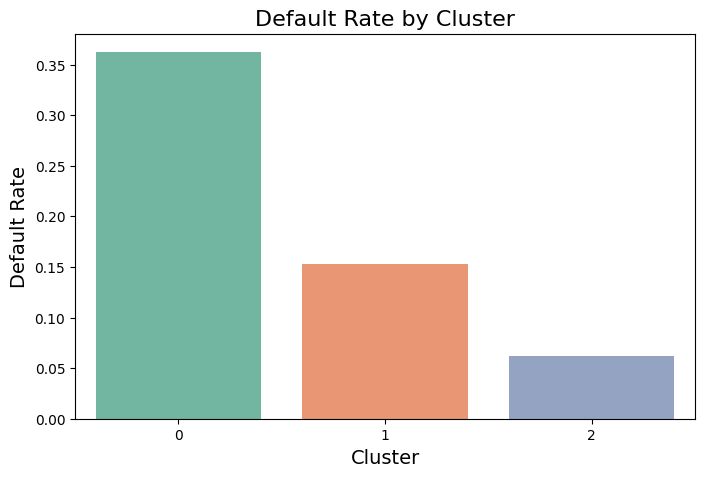

In [18]:
# Calculate the number of defaults and total observations in each cluster
cluster_analysis = fico.groupby('cluster').agg(
    total_observations=('default', 'count'),
    defaults=('default', 'sum')
)

# Add a default rate column
cluster_analysis['default_rate'] = cluster_analysis['defaults'] / cluster_analysis['total_observations']

# Print the analysis
print(cluster_analysis)

# Visualize the default rates
plt.figure(figsize=(8, 5))
sns.barplot(
    x=cluster_analysis.index,
    y=cluster_analysis['default_rate'],
    hue=cluster_analysis.index,  # Assign hue explicitly to match the x-axis
    palette='Set2',
    dodge=False  # Avoid splitting bars since we don't need grouped bars
)
plt.title('Default Rate by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Default Rate', fontsize=14)
plt.legend([], [], frameon=False)  # Remove legend since it's redundant
plt.show()


In [19]:
#compute the range for each cluster
fico_ranges = fico.groupby('cluster')['fico_score'].agg(['min', 'max']).reset_index()
# Print the ranges
fico_ranges

,cluster,min,max
0,0,408,600
1,1,601,675
2,2,676,850


In [20]:
# Merge the two tables
fico_defaultRate = cluster_analysis.merge(fico_ranges, left_index=True, right_on='cluster')
# Reorder the columns
fico_defaultRate = fico_defaultRate[['cluster', 'min', 'max', 'total_observations', 'defaults', 'default_rate']]
# Display the reordered DataFrame
fico_defaultRate


,cluster,min,max,total_observations,defaults,default_rate
0,0,408,600,2682,972,0.362416
1,1,601,675,4659,714,0.153252
2,2,676,850,2659,165,0.062053


The clustering analysis of FICO scores reveals three distinct risk categories for borrowers based on their credit scores:

- High-Risk Borrowers (Cluster 0): Borrowers in this cluster represent the highest default risk, with over one-third of borrowers defaulting. This group has the lowest FICO scores.
- Medium-Risk Borrowers (Cluster 1):Borrowers in this cluster have a moderate risk of default, with a significantly lower default rate compared to the high-risk group.
- Low-Risk Borrowers (Cluster 2): This group represents the lowest default risk, with less than 7% of borrowers defaulting. They have the highest FICO scores, indicating strong creditworthiness.

LOG-LIKELIHOOD

K-means distangled the number of possible boundaries. These can serve as  starting boundaries for the log-likelihood maximization. 
At this time, k-means clustering, log likelihood and dynamic are applied altogether.

(Prior to apply them, functions for log-likelihood and dynamic programming are defined)

In [21]:
#define a function to compute log_likelihood
def compute_log_likelihood(df, boundaries):
    """
    Compute the log-likelihood for a given set of boundaries.
    """
    log_likelihood = 0
    prev_boundary = 0  # Starting boundary
    
    for i in range(len(boundaries)):
        # Select the records within the current bucket range
        bucket_data = df[(df['fico_score'] > prev_boundary) & (df['fico_score'] <= boundaries[i])]
        ni = len(bucket_data)  # Total records in the bucket
        ki = bucket_data['default'].sum()  # Number of defaults
        
        if ni > 0:
            pi = ki / ni  # Probability of default
            log_likelihood += ni * (ki * np.log(pi) + (ni - ki) * np.log(1 - pi))
        
        prev_boundary = boundaries[i]  # Update the previous boundary
    
    return log_likelihood

In [22]:
#define a function to employ dynamic programming
def dynamic_programming_quantization(df, initial_boundaries, num_buckets):
    """
    Use dynamic programming to find the optimal bucket boundaries.
    
    Arguments:
    - df: DataFrame containing the FICO scores and default information.
    - initial_boundaries: Initial set of boundaries (e.g., k-means centroids).
    - num_buckets: The number of buckets to create.
    
    Returns:
    - optimal_boundaries: The optimal boundaries based on the log-likelihood maximization.
    """
    # DP table to store the best log-likelihood for each state
    dp_table = np.full((len(initial_boundaries), num_buckets), -np.inf)
    
    # Base case: First column corresponds to 1 bucket, just use the initial boundary as is
    for i in range(len(initial_boundaries)):
        dp_table[i, 0] = compute_log_likelihood(df, [0] + [initial_boundaries[i]] + [850])

    # Fill the DP table
    for k in range(1, num_buckets):
        for i in range(k, len(initial_boundaries)):
            best_ll = -np.inf
            best_boundary = None
            for j in range(k-1, i):
                current_boundaries = list(initial_boundaries[j:i+1]) + [850]
                log_ll = compute_log_likelihood(df, [0] + current_boundaries)
                if log_ll > best_ll:
                    best_ll = log_ll
                    best_boundary = current_boundaries
            dp_table[i, k] = best_ll

    # Reconstruct the optimal boundaries
    optimal_boundaries = []
    j = len(initial_boundaries) - 1
    for k in range(num_buckets - 1, -1, -1):
        optimal_boundaries.insert(0, initial_boundaries[j])
        j -= 1
    
    return optimal_boundaries, dp_table[-1, num_buckets-1]

The first step is to set the initial boundaries as the one coming from the k-mean model.

In [23]:
#set the k-mean clusters as initial boundaries
initial_boundaries = np.sort(kmeans3.cluster_centers_.flatten())

Then, it is necessary to select the number of buckets. At the moment, the choice is 3 (as pointed by the k-mean algorithm)

In [24]:
#set the number of buckets
num_buckets = 3

Finally, it is possible to turn to log likelihood combined with dynamic programming.

In [ ]:
#compute optimal boundaries and employ dynamic programming
optimal_boundaries, best_log_likelihood = dynamic_programming_quantization(fico, initial_boundaries, num_buckets)


It is now time to visualize the results. First, the table with buckets is printed then it is plotted.

In [25]:
# function to analyze the results of optimal boundaries
def analyze_buckets(df, boundaries):
    """
    Analyze the buckets based on the optimal boundaries.
    
    Arguments:
    - df: DataFrame containing FICO scores and default labels.
    - boundaries: List of optimal boundaries.
    
    Returns:
    - bucket_analysis: DataFrame summarizing the bucket statistics.
    """
    # Add 0 as the minimum and 850 as the maximum boundary for analysis
    boundaries = [0] + boundaries + [850]
    bucket_data = []

    # Calculate metrics for each bucket
    for i in range(1, len(boundaries)):
        min_score = boundaries[i-1]
        max_score = boundaries[i]
        bucket_df = df[(df['fico_score'] > min_score) & (df['fico_score'] <= max_score)]

        total_observations = len(bucket_df)
        defaults = bucket_df['default'].sum()
        default_rate = defaults / total_observations if total_observations > 0 else 0

        bucket_data.append({
            'Bucket': i-1,
            'Min Score': min_score,
            'Max Score': max_score,
            'Total Observations': total_observations,
            'Defaults': defaults,
            'Default Rate': default_rate
        })

    # Convert to DataFrame
    bucket_analysis = pd.DataFrame(bucket_data)
    return bucket_analysis

In [29]:
#perform the bucket analysis
bucket_analysis = analyze_buckets(fico, optimal_boundaries)
#fix the lowest boundaries: it can not be 0, but 300 (the minimum values fico can take)
bucket_analysis.loc[bucket_analysis['Bucket'] == 0, 'Min Score'] = 300
# Round the specific columns to 3 decimals
bucket_analysis['Min Score'] = bucket_analysis['Min Score'].round(3)
bucket_analysis['Max Score'] = bucket_analysis['Max Score'].round(3)
bucket_analysis['Default Rate'] = bucket_analysis['Default Rate'].round(3)
#show buckets analysis
print("Bucket Analysis:")
bucket_analysis

Bucket Analysis:


,Bucket,Min Score,Max Score,Total Observations,Defaults,Default Rate
0,0,300.000,562.466,1080,516,0.478
1,1,562.466,638.482,3933,899,0.229
2,2,638.482,711.680,3880,391,0.101
3,3,711.680,850.000,1107,45,0.041


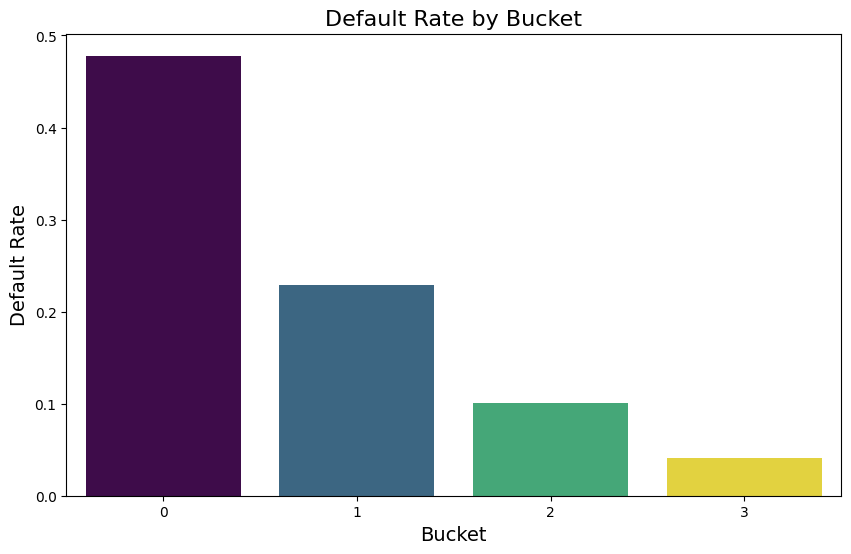

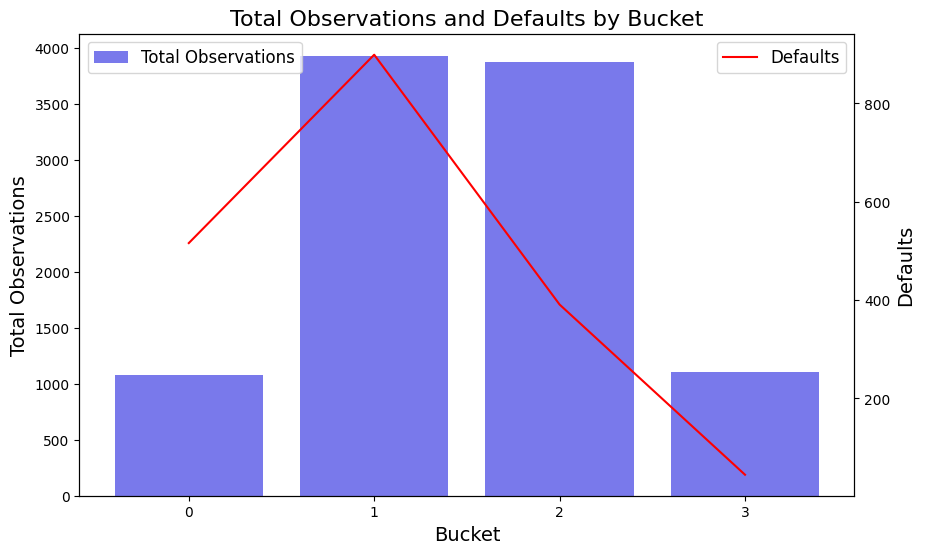

In [35]:
# Visualize the results
# Default rate by bucket
plt.figure(figsize=(10, 6))
sns.barplot(data=bucket_analysis,
            x='Bucket',
            y='Default Rate',
            hue='Bucket',
            palette='viridis',
            dodge=False,
            legend=False)
plt.title('Default Rate by Bucket', fontsize=16)
plt.xlabel('Bucket', fontsize=14)
plt.ylabel('Default Rate', fontsize=14)
plt.show()

# Observations and Defaults by Bucket
fig, ax1 = plt.subplots(figsize=(10, 6))
# Total observations
sns.barplot(data=bucket_analysis, x='Bucket', y='Total Observations', color='blue', alpha=0.6, label='Total Observations', ax=ax1)
ax1.set_ylabel('Total Observations', fontsize=14)
ax1.set_xlabel('Bucket', fontsize=14)
ax1.set_title('Total Observations and Defaults by Bucket', fontsize=16)
# Defaults
ax2 = ax1.twinx()
sns.lineplot(data=bucket_analysis, x='Bucket', y='Defaults', color='red', label='Defaults', ax=ax2)
ax2.set_ylabel('Defaults', fontsize=14)
# Combine legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
plt.show()

Why buckets changed from 3 to 4? 
That's because the dynamic programming algorithm tries to find the optimal way to split the FICO score range into buckets while minimizing the log-likelihood cost. During this process, it may have decided that splitting data into 4 buckets (instead of strictly 3) results in better alignment with the default probabilities and densities in the data. Plus, dynamic programming can "override" the initial number of buckets to maximize the fit or minimize the error.

BUCKET OVERVIEW

- Bucket 0 (300–562.466): This group represents borrowers with the lowest FICO scores. They exhibit the highest default rate of 47.8%. This bucket accounts for 1,080 observations, highlighting a high-risk category.
- Bucket 1 (562.466–638.482): Borrowers in this range have a default rate of 22.9%, showing moderate risk.With 3,933 observations, this bucket captures the largest segment of borrowers.
- Bucket 2 (638.482–711.680): This bucket represents borrowers with relatively strong credit scores and a default rate of just 10.1%. It includes 3,880 observations, indicating a substantial group of low-risk borrowers.
- Bucket 3 (711.680–850): Borrowers in this range have the highest FICO scores and are the lowest-risk group, with a default rate of only 4.1%. This bucket has 1,107 observations, reflecting the safest borrowers.

KEY INSIGHTS

Risk Stratification:
The segmentation effectively identifies distinct risk levels based on FICO scores, with default rates steadily decreasing as scores increase.
This insight can be used to design targeted credit strategies, such as offering lower interest rates or higher credit limits to borrowers in buckets 2 and 3.

High-Risk Borrowers (Bucket 0):
Borrowers in this bucket show nearly a 1-in-2 chance of default. Proactive measures, such as stricter credit policies or additional risk mitigation strategies, should be implemented for this group.

Moderate-Risk Borrowers (Bucket 1):
This bucket, while less risky than Bucket 0, still accounts for a significant portion of defaults due to its size. Careful monitoring and pricing adjustments are recommended.

Actionable Strategy:
- Credit policies: Focus on allocating resources to lower-risk groups (Buckets 2 and 3) for profitability, while tightening risk management for higher-risk groups (Buckets 0 and 1).
- Loan offerings: Use this segmentation to personalize loan offers and conditions based on default risk.